<a href="https://colab.research.google.com/github/GyeeunJeong/Hands-on-ML/blob/main/ch3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mnist
- 데이터셋 다운로드

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [ ]:
mnist

{'DESCR': "**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered i

In [ ]:
X, y = mnist['data'], mnist['target']

In [ ]:
# 70,000 개의 이미지, 784 개의 특성 (이미지 28X28 픽셀)
X.shape, y.shape

((70000, 784), (70000,))

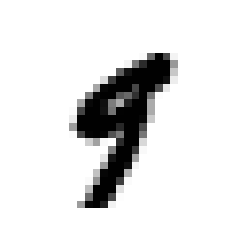

In [ ]:
# 이미지 확인
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X.loc[36000]
some_digit_image = some_digit.values.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [ ]:
y.loc[36000]

'9'

In [ ]:
# train, test dataset 분리
X_train, X_test, y_train, y_test = X.loc[:60000], X.loc[60000:], y.loc[:60000], y.loc[60000:]

In [ ]:
# 훈련세트를 섞어 모든 교차 검증 폴드가 비슷해지게 함
# 알고리즘에 따라 비슷한 샘플이 연이어 나타나면 성능이 나빠지는 경우 있어 데이터셋을 섞어즘 (ex. SGDClassifier, SGDRegressor)
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train.loc[shuffle_index], y_train.loc[shuffle_index]

In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# 이진 분류기 훈련 (binary classifier)
- ex. 5 인지 아닌지만 판단
- SGDClassifier(Stochastic Gradient Descent): 확률적 경사 하강법
- 큰 데이터셋을 효율적으로 처리. 한번에 하나씩 훈련 샘플을 독립적으로 처리
- 온라인 학습에 잘 맞음

In [ ]:
# 타깃 벡터 만들기
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train.values, y_train_5.values)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


SGDClassifier(max_iter=5, random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([False])

# 성능 측정
1. 교차 검증 사용한 정확도 측정

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


array([0.9615, 0.9037, 0.9686])

In [ ]:
from sklearn.base import BaseEstimator

# 모든 이미지를 '5 아님'아님' 클래스로 분류하는 더미 분류기
# 5 클래스가 전체 이미지의 10%이기 때문에 무조건 5 아님으로 예측해도 정확도 90% 나옴
# 정확도를 성능지표로 선호하지 않는 이유. 불균형 데이터셋을 다룰 때 특히 더욱 그럼.
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9122 , 0.9078 , 0.90895])

In [ ]:
# 교차 검증 구현 (교차 검증 과정을 많이 제어해야 하는 경우)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.loc[train_index]
  y_train_folds = y_train_5.loc[train_index]
  X_test_fold = X_train.loc[test_index]
  y_test_fold = y_train_5.loc[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred==y_test_fold)
  print(n_correct/len(y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


0.9626


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


0.9307
0.95735


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


2. 오차 행렬
- 행: 실제 클래스(0, 1)
- 열: 예측 클래스(0, 1)
- TN FP
- FN TP
- 정밀도(precision) = TP/(TP+FP)
- 재현율(recall, 민감도) = TP/(TP+FN)

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52492,  2087],
       [ 1237,  4184]])

3. 정밀도와 재현율
- f1 score = 2X(정밀도X재현율)/(정밀도+재현율)
- f1 score가 높으면 좋지만 항상 바람직한 것은 아님
- 상황에 따라 정밀도가 중요할 수도, 재현율이 중요할 수도 있음
- ex. 아이에게 안전한 동영상 거르는 분류기라면? 안전한 것들만 노출시키는 분류기 선호 (높은 정밀도 필요)
- ex. 감시 카메라로 도둑 잡는 분류기라면? 재현율 높은게 중요
- 정밀도와 재현율은 트레이드오프 관계

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.6671982140009568, 0.7718133185759085)

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7157030448169689

In [ ]:
# decision function 이용해서 각 샘플의 점수 계산. (임계값보다 크면 양성, 아니면 음성)
# 예측을 결정하는 결정 임곗값이 커지면 정밀도가 높아지고 재현율이 낮아짐
# 임곗값이 낮아지면 정밀도가 낮아지고 재현율이 높아짐
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-196347.76406587])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
threshold - 200000
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

array([False])

In [ ]:
# 예측 결과가 아니라 결정 점수를 반환 받아 지정
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_

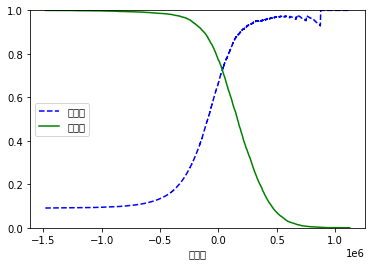

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
  plt.plot(thresholds, recalls[:-1], 'g-', label='재현율')
  plt.xlabel('임계값')
  plt.legend(loc='center left')
  plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
y_train_pred_90 = (y_scores>70000)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.848990342405619

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.7135214904999078

4. ROC 곡선 
- 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)
- 민감도(재현율)에 대한 1-특이도 그래프
- 재현율 높을수록 거짓양성(fpr) 늘어남
- 대각선: 랜덤 분류기의 ROC
- 좋은 분류기는 대각선에서 최대한 멀리 떨어짐
- AUC: 곡선 아래의 면적 (완벽한 ROC는 AUC가 1, 완전한 랜덤 분류기는 0.5)
- 양성클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요하면 PR 곡선 사용 (PR: 정밀도/재현율 곡선)
- PR곡선은 분류기의 성능 개선 여지가 얼마나 되는지 보여줌 (오른쪽 위 모서리에 가까워질 수 있는지) 

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51667 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_

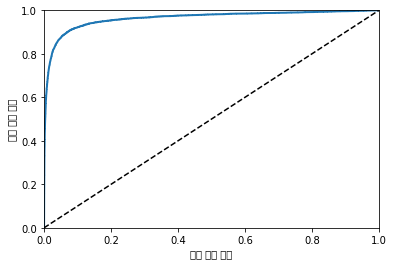

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('거짓 양성 비율')
  plt.ylabel('진짜 양성 비율')

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9624925017176048

In [ ]:
# ROC와 ROC AUC점수 계산
# decision function 함수가 없어서 predict proba로 대체
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
                                    
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

5. 다중 분류
- 둘 이상의 클래스 구별
- 이진분류만 가능한 알고리즘이라도 여러 개를 사용해 다중 클래스 분류 가능
- 이진분류만 가능: 서포트 벡터 머신, 선형 분류
- 여러 클래스 직접 처리 가능: 랜덤 포레스트, 나이브 베이즈
- 방법
  - 1) 일대다 전략(OvA, one-versus-all): 클래스마다 이진분류기를 만들어서 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택
  - 2) 일대일 전략(OvO, one-ersus-one): 각 클래스 조합마다 이진 분류기를 훈련. 클래스가 N개라면 분류기는 NX(N-1)/2개 필요. 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것.
  - 훈련 세트 크기에 민감하다면 OvO (서포트 벡터 머신)
  - 대부분 OvA 선호
- 다중 클래스 분류 작업에서 이진 클래스 선택하면 사이킷런에서 자동으로 OvA 선택(SVM에서는 OvO)

In [ ]:
# y_train_5 대신 0에서 9까지 다중 클래스가 있는 y_train 사용
# OvA를 통해 10개의 이진 분류기 훈련 시켜 점수가 가장 높은 클래스 선택
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array(['5'], dtype='<U1')

In [ ]:
# 클래스마다 하나씩, 총 10개의 점수 반환
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[-696237.72154478, -372874.46141249, -738827.41669272,
        -195353.80727659,  -90936.63295457,  -49712.29503663,
        -916881.55415722, -262578.74412304, -305167.80536533,
        -320093.86782723]])

In [ ]:
# 점수가 가장 높은 클래스는 4
np.argmax(some_digit_scores)

4

In [ ]:
sgd_clf.classes_[4]

'4'

In [ ]:
# OvO 또는 OvA를 사용하도록 강제
# OvO : OneVsOneClassifier, OvA: OneVsRestClassifier
# OvO를 이용해 SGD 다중 분류
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

array(['9'], dtype=object)

In [ ]:
len(ovo_clf.estimators_)

45

In [ ]:
# RandomForest 훈련. 직접 샘플을 다중 클래스로 분류할 수 있어 OvO, OvA 적용할 필요 없음
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array(['9'], dtype=object)

In [ ]:
forest_clf.predict_proba([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.9]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


array([0.87385, 0.864  , 0.83055])

In [ ]:
# 스케일 조정해서 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


array([0.9104 , 0.90825, 0.9112 ])

# 에러 분석
- 모델 성능 향상시킬 방법.
- 에러의 종류 분석

In [ ]:
# 오차 행럴
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


array([[5741,    2,   17,    6,    9,   48,   43,    8,   45,    4],
       [   1, 6468,   44,   27,    4,   38,    7,   11,  127,   15],
       [  58,   33, 5318,   99,   88,   19,   93,   67,  164,   19],
       [  51,   37,  139, 5366,    1,  211,   40,   52,  133,  101],
       [  21,   21,   33,   10, 5348,    6,   50,   38,   87,  228],
       [  78,   40,   40,  189,   72, 4584,  106,   29,  181,  102],
       [  35,   24,   40,    2,   37,   88, 5638,    7,   46,    1],
       [  23,   19,   63,   26,   54,   11,    5, 5812,   16,  236],
       [  50,  145,   68,  154,   12,  153,   54,   26, 5036,  153],
       [  42,   25,   25,   94,  152,   30,    2,  214,   79, 5286]])

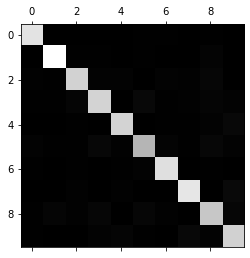

In [ ]:
# 대부분 주대각선에 분류되어 오차행렬이 좋아보임
# 숫자 5는 조금 어두워보임 (숫자 5의 이미지가 적거나 5를 잘 분류 못한다는 뜻)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# 클래스의 이미지 개수로 나누어 에러 비율 비교 (에러의 개수로 비교하는 것 아님)
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx/row_sums

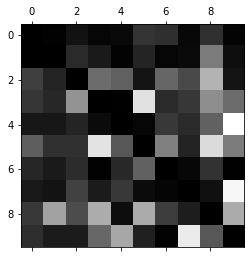

In [ ]:
# 행: 실제 클래스, 열: 예측한 클래스
# 클래스 8, 9의 열이 밝음 -> 많은 이미지가 8, 9로 잘못 분류됨
# 클래스 8, 9의 행이 밝음 -> 숫자 8, 9가 다른 숫자들과 자주 혼돈됨
# 클래스 1의 열 어두움 -> 대부분의 숫자 1이 정확하게 분류됨
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

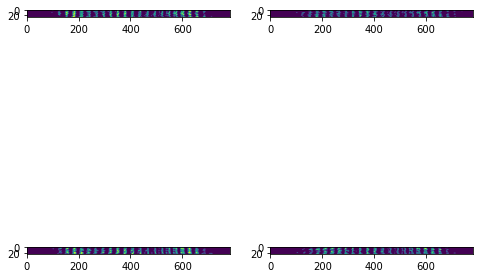

In [ ]:
# 성능 개선 방안: 성능이 안좋은 클래스의 훈련 데이터 더 수집, 분류기에 도움이 될 특성 찾기 등
# 개개의 에러를 분석하면 더 정확하지만 더 어려움
# 3, 5의 샘플
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plt.imshow(X_aa[:25])#, images_per_row=5)
plt.subplot(222); plt.imshow(X_ab[:25])#, images_per_row=5)
plt.subplot(223); plt.imshow(X_ba[:25])#, images_per_row=5)
plt.subplot(224); plt.imshow(X_bb[:25])#, images_per_row=5)
plt.show()

# 다중 레이블 분류
- 샘플마다 여러개의 클래스를 출력해야할 때.
- 여러 개의 이진 레이블을 출력하는 분류 시스템

In [ ]:
import pandas as pd

In [ ]:
y_train.shape

(60000,)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#temp = np.repeat('7', y_train.shape[0])
temp = pd.Series(y_train)
temp = temp.astype(int)

y_train_large = (temp >= 7)
y_train_odd = (temp%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit]) # some_digit: 9

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[ True,  True]])

In [ ]:
# 평가 방법
# 각 레이블의 F1점수 구해서 평균 계산
# 클래스마다 개수가 서로 차이가 나면 개수가 많은 클래스에 높은 가중치 줌 (지지도(support)로 가중치 주기, average='weighted')
# 여기선 모든 레이블의 가중치가 같다고 가정
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9771682945409477

# 다중 출력 분류
- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화

In [ ]:
# 이미지에서 노이즈 제거
# 먼저 randint()를 사용해 픽셀 강도에 노이즈 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


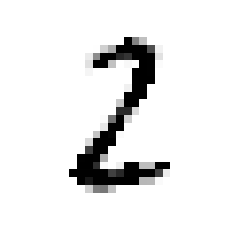

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.loc[63600]])

some_digit_image = clean_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()